In [ ]:
# Imports

# Notes

# Table of Contents

<br><br>
# **Hands-On: Deep Learning Fundamentals**

## Learning Goals
By the end of this session, you will be able to:

- **Understand neural network architecture and components**
  - Build multilayer perceptrons from scratch and understand their structure
  - Explore different activation functions and their roles in network learning

- **Master the learning process in neural networks**
  - Implement gradient descent and backpropagation for parameter optimization
  - Understand how networks learn complex patterns through iterative weight updates

- **Design and tune deep learning models effectively**
  - Configure network architectures and optimize hyperparameters
  - Apply regularization techniques to prevent overfitting in deep networks

- **Explore convolutional neural networks for image processing**
  - Understand convolution, pooling, and feature extraction in CNNs
  - Build image classification models and visualize learned features

- **Leverage pre-trained models with Hugging Face**
  - Use state-of-the-art pre-trained networks for image classification
  - Apply transformer models for text analysis and image generation tasks

- **Apply deep learning to real-world problems**
  - Compare traditional machine learning with deep learning approaches
  - Make informed decisions about when to use deep learning for different problem types

## What is a Neural Network?

A **neural network** is a computational model inspired by how biological neurons process information. At its core, it's a collection of interconnected nodes (neurons) that:

1. **Receive inputs** (like features from data)
2. **Apply weights** to these inputs (learned parameters)
3. **Add a bias term** (learned offset)
4. **Pass through an activation function** (introduces non-linearity)
5. **Produce an output** that feeds into the next layer

**Key components:**
- **Weights**: Determine the strength of connections between neurons
- **Biases**: Allow neurons to activate even when inputs are zero
- **Activation functions**: Non-linear functions (like ReLU, sigmoid, tanh) that enable networks to learn complex patterns

<img src="imgs/relu_nn.webp" alt="Neural Network Diagram" width="500"/>

## The Universal Approximation Theorem

Before diving into complex networks, let's understand a fundamental theorem:

> **Any continuous function can be approximated arbitrarily well by a neural network with just one hidden layer and enough neurons.**

This might sound abstract, but it's actually quite intuitive. Let's demonstrate this by showing how we can approximate a sine wave using only **ReLU (Rectified Linear Unit)** functions.

**ReLU function**: `ReLU(x) = max(0, x + b)` - simply outputs the scaled input if positive, zero otherwise.

The magic happens when we:
1. **Shift** ReLU functions using bias terms
2. **Scale** them using weights  
3. **Combine** multiple shifted/scaled ReLUs

Let's see this in action:

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, Layout
import ipywidgets as widgets

def interactive_relu_demo():
    """Interactive demonstration of how ReLU combinations create different functions"""
    
    # Create x-axis
    x = torch.linspace(-2, 2, 1000)
    
    def plot_relu_combination(weight1=1.0, bias1=0.0, weight2=-0.5, bias2=0.5, weight3=0.3, bias3=-1.0):
        """Plot combination of 3 ReLU functions with adjustable parameters"""
        
        # Compute individual ReLU functions
        relu1 = weight1 * torch.relu(x + bias1)
        relu2 = weight2 * torch.relu(x + bias2)  
        relu3 = weight3 * torch.relu(x + bias3)
        
        # Combine all ReLUs
        combined = relu1 + relu2 + relu3
        
        # Create the plot
        plt.figure(figsize=(14, 8))
        
        # Plot individual ReLUs
        plt.subplot(1, 2, 1)
        plt.plot(x, relu1, 'r-', linewidth=2, label=f'ReLU1: {weight1:.1f}*ReLU(x + {bias1:.1f})')
        plt.plot(x, relu2, 'g-', linewidth=2, label=f'ReLU2: {weight2:.1f}*ReLU(x + {bias2:.1f})')
        plt.plot(x, relu3, 'b-', linewidth=2, label=f'ReLU3: {weight3:.1f}*ReLU(x + {bias3:.1f})')
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
        plt.title('Individual ReLU Functions')
        plt.xlabel('x')
        plt.ylabel('ReLU(x)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim(-3, 3)
        
        # Plot combined function
        plt.subplot(1, 2, 2)
        plt.plot(x, combined, 'purple', linewidth=3, label='Combined Function')
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
        plt.title('Combined ReLU Function')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim(-3, 3)
        
        plt.tight_layout()
        plt.show()
        
    # Create interactive sliders
    weight_layout = Layout(width='300px')
    bias_layout = Layout(width='300px')
    
    interact(plot_relu_combination,
             weight1=FloatSlider(min=-2, max=2, step=0.1, value=1.0, description='Weight 1:', layout=weight_layout),
             bias1=FloatSlider(min=-2, max=2, step=0.1, value=0.0, description='Bias 1:', layout=bias_layout),
             weight2=FloatSlider(min=-2, max=2, step=0.1, value=1.0, description='Weight 2:', layout=weight_layout),
             bias2=FloatSlider(min=-2, max=2, step=0.1, value=0.5, description='Bias 2:', layout=bias_layout),
             weight3=FloatSlider(min=-2, max=2, step=0.1, value=1.0, description='Weight 3:', layout=weight_layout),
             bias3=FloatSlider(min=-2, max=2, step=0.1, value=-0.5, description='Bias 3:', layout=bias_layout))

interactive_relu_demo()

interactive(children=(FloatSlider(value=1.0, description='Weight 1:', layout=Layout(width='300px'), max=2.0, m…

You can see how just changing the **weight** (slope) and **bias** (shift) parameters creates completely different function shapes. This is the key insight:

- **Weight** controls how steep the ReLU ramp is
- **Bias** controls where the ReLU "turns on" (shifts the corner left/right)
- **Combining multiple ReLUs** with different weights and biases lets us build complex, piecewise-linear functions

Now you understand the building blocks! But can we really approximate **any** function? Let's put this to the test with a challenging target: **the sine function**.

The sine function is smooth and curved - quite different from the sharp, linear segments of ReLU functions. Yet the Universal Approximation Theorem tells us we can get arbitrarily close using enough ReLUs.

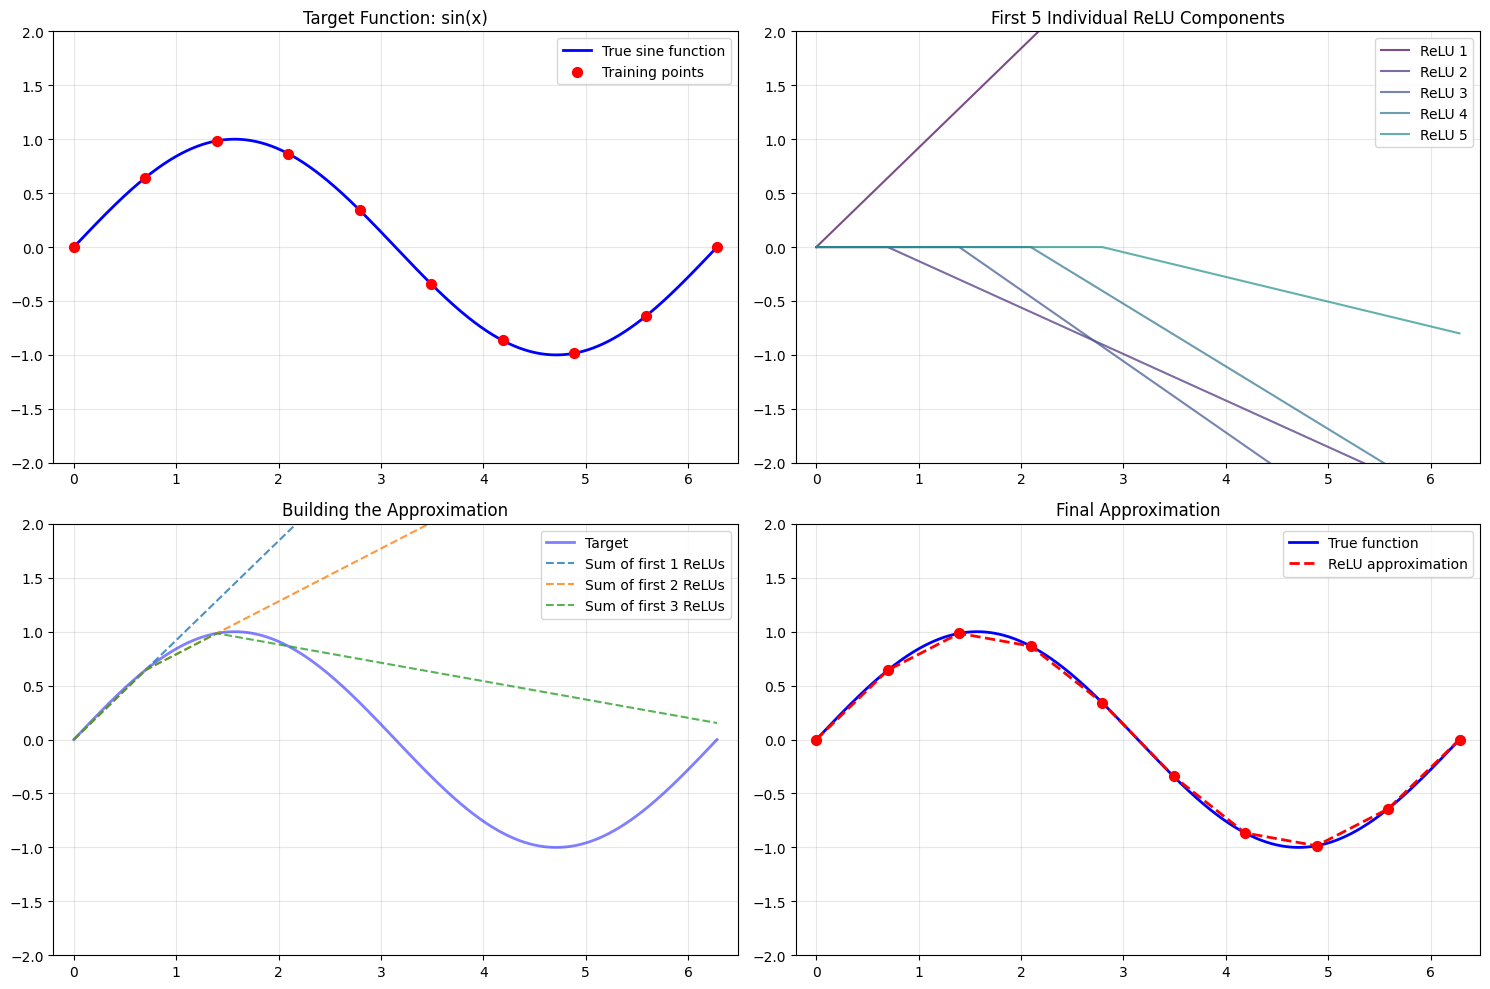

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def approximate_function(x_train, y_train):
    """
    Approximate any function using combination of ReLU activations
    
    Args:
        x_train: Training x points
        y_train: Training y points (target function values)
    
    Returns:
        y_hat: Approximated function values
        relu_acts: Individual ReLU activations
        x: Dense x-axis for plotting
    """
    
    # Number of ReLUs needed
    n_relus = x_train.shape[0] - 1
    
    # Dense x-axis for smooth plotting
    x = torch.linspace(torch.min(x_train), torch.max(x_train), 1000)
    
    ## COMPUTE RELU ACTIVATIONS
    # Set bias terms to "activate" ReLUs at training points
    b = -x_train[:-1]
    
    # Compute ReLU activations: ReLU(x + bias)
    relu_acts = torch.zeros((n_relus, x.shape[0]))
    for i_relu in range(n_relus):
        relu_acts[i_relu, :] = torch.relu(x + b[i_relu])
    
    ## COMBINE RELU ACTIVATIONS
    # Calculate weights to match target function slopes
    combination_weights = torch.zeros((n_relus,))
    
    prev_slope = 0
    for i in range(n_relus):
        delta_x = x_train[i+1] - x_train[i]
        slope = (y_train[i+1] - y_train[i]) / delta_x
        combination_weights[i] = slope - prev_slope
        prev_slope = slope
    
    # Final approximation: weighted sum of ReLUs
    y_hat = combination_weights @ relu_acts
    
    return y_hat, relu_acts, x, combination_weights

def plot_function_approximation(x, relu_acts, y_hat, combination_weights):
    """Plot the function approximation process"""
    
    # Original function for comparison
    y_true = torch.sin(x)

    # Set consistent axis limits for all plots
    x_lim = [float(torch.min(x))-0.2, float(torch.max(x))+0.2]
    y_lim = [-2, 2]  # Accommodate both sine function and individual ReLUs
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Original function
    axes[0,0].plot(x, y_true, 'b-', linewidth=2, label='True sine function')
    axes[0,0].scatter(x_train.flatten(), y_train.flatten(), color='red', s=50, zorder=5, label='Training points')
    axes[0,0].set_title('Target Function: sin(x)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Individual ReLU functions
    axes[0,1].set_title('First 5 Individual ReLU Components')
    colors = plt.cm.viridis(np.linspace(0, 1, relu_acts.shape[0]))
    for i in range(min(5, relu_acts.shape[0])):  # Show first 5 ReLUs
        axes[0,1].plot(x, combination_weights[i] * relu_acts[i], color=colors[i], alpha=0.7, label=f'ReLU {i+1}')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].set_xlim(x_lim)
    axes[0,1].set_ylim(y_lim)
    axes[0,0].set_xlim(x_lim)
    axes[0,0].set_ylim(y_lim)
    
    # Plot 3: Cumulative approximation
    axes[1,0].set_title('Building the Approximation')
    axes[1,0].plot(x, y_true, 'b-', linewidth=2, alpha=0.5, label='Target')
    
    # Show cumulative sum of ReLUs
    cumulative = torch.zeros_like(x)
    for i in range(min(3, relu_acts.shape[0])):
        cumulative += combination_weights[i] * relu_acts[i]
        axes[1,0].plot(x, cumulative, '--', alpha=0.8, label=f'Sum of first {i+1} ReLUs')
    
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].set_xlim(x_lim)
    axes[1,0].set_ylim(y_lim)
    
    # Plot 4: Final approximation
    axes[1,1].plot(x, y_true, 'b-', linewidth=2, label='True function')
    axes[1,1].plot(x, y_hat, 'r--', linewidth=2, label='ReLU approximation')
    axes[1,1].scatter(x_train.flatten(), y_train.flatten(), color='red', s=50, zorder=5)
    axes[1,1].set_title('Final Approximation')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].set_xlim(x_lim)
    axes[1,1].set_ylim(y_lim)
    
    plt.tight_layout()
    plt.show()

# Generate training data from sine function
N_train = 10
x_train = torch.linspace(0, 2*np.pi, N_train).view(-1, 1)
y_train = torch.sin(x_train)

# Approximate the function
y_hat, relu_acts, x, combination_weights = approximate_function(x_train, y_train)

# Visualize the approximation process
plot_function_approximation(x, relu_acts, y_hat, combination_weights)

Our ReLU approximation captures the sine wave's shape quite well, even with just 9 ReLU functions (from 10 training points). 

- The approximation follows the general sine curve structure
- It perfectly matches at all training points (red dots)
- The piecewise-linear nature creates small "corners" but the overall shape is preserved

Want even better precision? We can increase the number of training points, which gives us more ReLU functions to work with. More ReLUs = more linear segments = smoother approximation!

## From Theory to Practice: Building Neural Networks

Now that we understand **why** neural networks work (Universal Approximation Theorem), let's learn **how** to build them in practice. 

**What we've seen so far:**
- Individual ReLU functions can be combined to approximate any function
- We manually calculated the weights and biases for our sine approximation

**What's next:**
- Build a real **Multilayer Perceptron (MLP)** using PyTorch
- Let the network **learn** the weights automatically through training
- Apply it to a **classification problem** (something more practical than function approximation)

**The key insight**: Instead of manually calculating weights like we did for the sine function, we'll use **gradient descent** to let the network find the best weights by learning from data.

Let's start building!

# **Multilayer Perceptron (MLP) with PyTorch**

An MLP is simply multiple layers of neurons connected together:
- **Input layer**: Receives the data
- **Hidden layer(s)**: Process the data with weights, biases, and activation functions
- **Output layer**: Produces predictions

# Gradient Descent / backpropagation